#**Team Microsoft**
####*David Netter, Deniz Kaan Varturk, Lucas Oggier*
<img src=https://alexmeub.com/assets/win98-icons-1.png width="300">


> Structure of the notebook:

1.   Introduction

2.   EDA

3.   Cleaning data

4.   Machine learning models building

5.   Submission for the contest

> Image source: https://bit.ly/370FkAE

# **I**. Introduction
####Steps :
- import packages and dataframes
- plot our AICrowd score evolution 
- compute the base rate for the training data


In [ ]:
import pandas as pd 
import seaborn as sns
import numpy as np
import re
import string
import sklearn
import csv,json

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stpw

#sns.set_style("white")
#%load_ext autoreload
#%autoreload 2
#from sklearn import datasets


#%load_ext autoreload
#%autoreload 2

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/training_data.csv")

df_test = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/test_data.csv")

df

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


###1.1 Accuracy score evolution

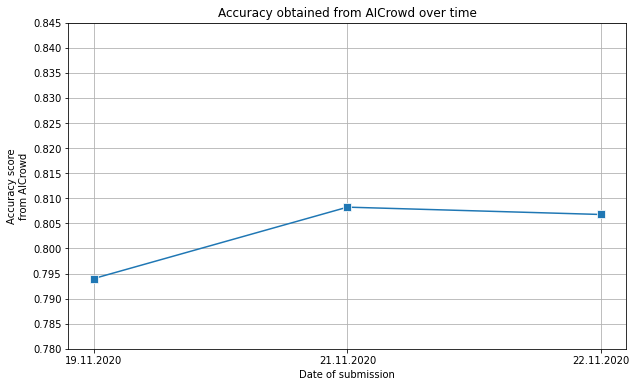

In [ ]:
#Import the log of accuracy score evolution
accuracy_log = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/submission_log.csv",sep = ';')

#Plot the scores over time
range_y = np.arange(0.780,0.850,step=0.005)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
sns.lineplot(data = accuracy_log,x='date',y='Accuracy', marker="s", ms=8, markevery=None)
plt.ylabel("Accuracy score\nfrom AICrowd")
plt.xlabel("Date of submission")
plt.title('Accuracy obtained from AICrowd over time')
plt.yticks(range_y)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

#Display plot
plt.show()

### 1.2: Base rate

In [ ]:
br = df.target.value_counts().max()/df.target.value_counts().sum()
number_per_class = df.target.value_counts()

values = {'target': [0 , 1],'counts': number_per_class}
df_base_rate = pd.DataFrame(data = values)
print(df_base_rate.to_string(index=False),'\n')
print("-> Base rate is",str(round(br,2)))

 target  counts
      0    3701
      1    2770 

-> Base rate is 0.57


# **II**. EDA
####Steps : 
- to fill

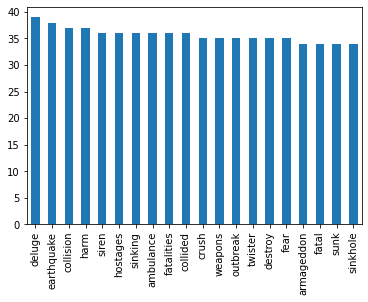

In [ ]:
#Analyzing the content of the keywords
df["keyword"].value_counts()[:20].plot(kind="bar")

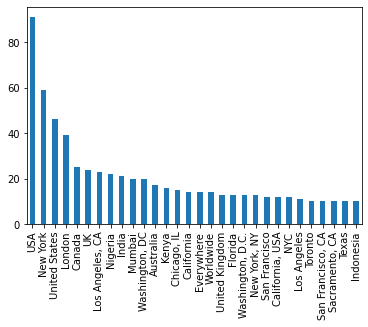

In [ ]:
#analyzing the content in the "location" column
df["location"].value_counts()[:30].plot(kind="bar")

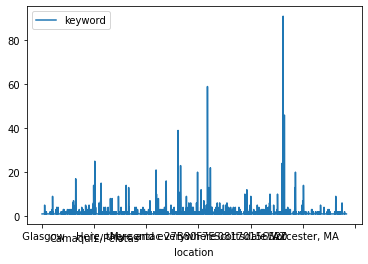

In [ ]:
#using pivot tables
pivot=pd.pivot_table(
    data=df,
    index="location",
    values='keyword',
    aggfunc='count'
)
pivot.plot() ## find a way to make the figure bigger

# **III**. Cleaning
####Steps : 
- defined a tokenzation function
- defined a preprocessing function applying on tweets & keywords
- application of the second function on training data

In [ ]:
### Notes: If you look at the table up, you can see that there are many NaN locations, maybe we should do something about it? - location pas incluse dans le modèle
### I believe that our submission might not have worked because of the duplicate removal
### Our accuracy could be better also if we replace %20 by a space, maybe the keywords are badly encoded!
### Is it normal that "mytokens = word" appears twice in the remove hashtags, @ section?

In [ ]:
sp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_token(message):
    
  mytokens = sp(message)
  # Lemmatize each token and convert each token into lowercase
  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

  # Remove stop words and punctuation
  mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

  # Remove hashtags, @
  mytokens = [ word.replace('@','').replace('#', '') for word in mytokens ]

  mytokens = [ word.replace('rt @', '').replace('rt', '') for word in mytokens ]
      
  mytokens = [ word for word in mytokens if word not in [""] ]

  return mytokens

def preprocess(dataframe):
  # Pre-processing text, of dataframe
  # for each row in dataframe: 
  #   get 'text' value (tweets), clean it (lemmatize - lowercase - remove stop words + punctuations), set cleaned 'text' value
  #   get 'keyword' value, replace the '%20' with <space>

  for index in dataframe.index:

    # < TEXT >

    # Get TEXT value
    text_to_clean = str(dataframe.at[index,'text'])

    # Remove hyperlink (http:/t.co.....)
    text_to_clean = re.sub(r"http\S+", "", text_to_clean)

    text_to_clean = re.sub(r"\S+", "", text_to_clean)

    # Build cleaned TEXT
    text_cleaned = ''.join(text_to_clean)

    # Cleaned TEXT into dataframe
    dataframe.at[index,'text'] = text_cleaned

    # < KEYWORD >

    # Get 'KEYWORD' value
    keyword_to_clean = str(dataframe.at[index,'keyword'])

    # Remove '%20'
    keyword_cleaned = keyword_to_clean.replace("%20"," ")

    # Cleaned KEYWORD into dataframe
    dataframe.at[index,'keyword'] = keyword_cleaned

  return dataframe

#df = df.drop(columns=['id'])

df = preprocess(df)

df
#for x in range(100,200):
#  print(df["location"][x])





,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


In [ ]:
#pivot table with 2 variables:
pivot2=pd.pivot_table(
    data=df,
    index='location',
    columns='keyword',
    values='target',
    aggfunc='count'
)
pivot2.head()
## i see that we have terms like "annihilated" and "annihilation" / "arson" and "arsonist" / "attack" and "attacked" / "bioterror" and "bioterrorism" - i remember there being somewhere in the course where we could group similar words together - maybe it is something to try?

keyword,ablaze,accident,aftershock,airplane accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew up,blight,blizzard,blood,bloody,blown up,body bag,body bagging,body bags,bomb,bombed,bombing,bridge collapse,buildings burning,buildings on fire,burned,burning,burning buildings,bush fires,...,snowstorm,storm,stretcher,structural failure,suicide bomb,suicide bomber,suicide bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent storm,volcano,war zone,weapon,weapons,whirlwind,wild fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Glasgow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
"Melbourne, Australia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
å_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45å¡ 5'12.53N 14å¡ 7'24.93E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **IV**. Train a model
####Steps and characteristics : 
- split train/test (80/20)
- define TF-IDF vectorizer
- define classifier
- fit model on training set
- first evaluation

In [ ]:
X = df['text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

X_train

# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_token)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=59)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                ('classifier', classifier)])


In [ ]:
# Fit model on training set
pipe.fit(X_train, y_train)

nFeat = 0
for i in tfidf.get_feature_names():
  nFeat += 1
print("number of features created by the TF-IDF vector :",str(nFeat))

y_pred = pipe.predict(X_test)

#first evaluation
print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, pipe.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

number of features created by the TF-IDF vector : 2286
ACCURACY SCORE test:
0.788
ACCURACY SCORE train:
0.859
CONFUSION MATRIX:
[[644  99]
 [175 377]]


# **V**. Submission : let's build predictions !
####Steps : 
- mount the drive in order to save the csv with submission values
- make a set of predictions on test_data, using the model defined above 

In [ ]:
#Mount a google drive
from google.colab import drive

drive.mount('drive')


#To improve performance : drop unused columns ('id' for now)
test_data = df_test['text']


# Get & print the number of features generated by the TF-IDF vector
nFeat = 0
for i in tfidf.get_feature_names():
  nFeat += 1
print("number of features created by the TF-IDF vector :",str(nFeat))

test_pred = pipe.predict(test_data)
print(type(test_pred))
print(test_pred)

#first evaluation
print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, pipe.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

Mounted at drive
number of features created by the TF-IDF vector : 2286
<class 'numpy.ndarray'>
[0 0 1 ... 1 0 1]
ACCURACY SCORE test:
0.788
ACCURACY SCORE train:
0.859
CONFUSION MATRIX:
[[644  99]
 [175 377]]


In [ ]:
#### We should try to create an index, like add the timestamp to the file name so we can run this and not overwrite the previous submissions
### OR we can also name the file: submission-[ACCURACYSCORE].csv

In [ ]:
#Handle the submission file
submission_file = pd.DataFrame(test_pred,columns=['target'])

submission_file.to_csv('submission_toSubmit.csv', index=False)

!cp submission_one.csv "drive/My Drive/Team_Microsoft"